In [1]:
import numpy as np
import pandas as pd
import feather

from scipy.stats import kurtosis, skew
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60
plt.style.use("tableau-colorblind10")

For details on how the dataframe was cleaned see gstore_revenue_cleaning. 

#### NOTE: Revenue has already been logtransformed here, so the numbers quoted will be Log(Transaction Revenue +1). For convenience will sometimes just refer to it as revenue

In [3]:
train_df = feather.read_dataframe('data/clean_train_v2.feather')

# Initial Exploratory Analysis

## Target Variable Distributions

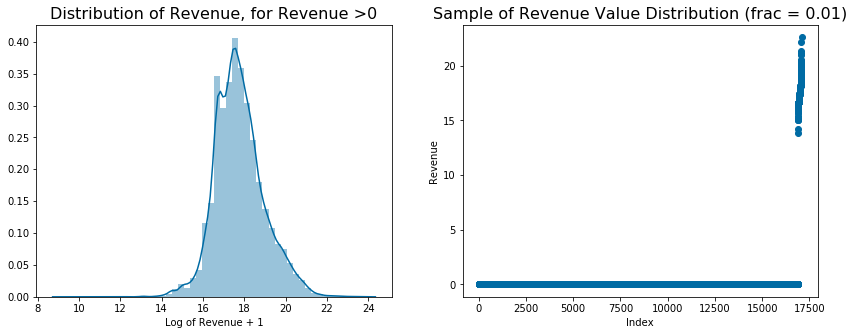

In [4]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"],hist = True, bins = 50)
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16)

plt.subplot(1,2,2)
plt.scatter(range(train_df.sample(frac = 0.01, random_state = 1).shape[0]), np.sort(train_df.sample(frac = 0.01, random_state = 1)['totals.transactionRevenue'].values))
plt.xlabel('Index')
plt.ylabel('Revenue')
plt.title('Sample of Revenue Value Distribution (frac = 0.01)', fontsize = 16);

In [5]:
kurtosis(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])

1.057531376381153

In [6]:
skew(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])

0.38092213710384065

Relative high kurtosis, moderate skew. 

## ARPU, ARPPU

In [8]:
userTotalRev = train_df[['fullVisitorId', 'totals.totalTransactionRevenue', 'spender']].drop_duplicates()

In [9]:
userTotalRev['totals.totalTransactionRevenue'].sum()/len(userTotalRev)

0.24854345338929923

In [10]:
userTotalRev.loc[userTotalRev['spender']]['totals.totalTransactionRevenue'].sum()/len(userTotalRev.loc[userTotalRev['spender']])

20.38315008704648

Right now will not split this by different dimensions.
Want to come back and find a way to ensure that every fullVisitorId only has one channelGrouping? 
Not sure how to do that right now. 

## Transaction Revenue By Other Dimensions
### Channel Grouping

Most popular browser channelGrouping is OrganicSearch

But Referal, Display, and Paid Search result in the highest conversion rates to spending per transaction.

But when just considering spending transactions the different channelGroupings the highest median transaction revenue comes from Display, with Affiliates the lowest.
(Just one transaction for (Other))

In [11]:
train_df.loc[(train_df['channelGrouping'] == '(Other)') & (train_df['totals.transactionRevenue'] > 0)]

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour,trafficSource.campaignCode,totals.totalTransactionRevenue,spender
1560539,(Other),2017-04-18,9907138721210043039,1492543413,1,1492543413,Chrome,iOS,True,mobile,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Jose,(not set),1,17,16,0,1,356,16.117095,(not set),google,(not set),False,True,1,18,4,2017,19,None,16.117095,True


In [12]:
channelGrouping_pct = pd.DataFrame(np.round(100*(train_df.groupby('channelGrouping')['totals.transactionRevenue'].count()/len(train_df)),2)).reset_index()

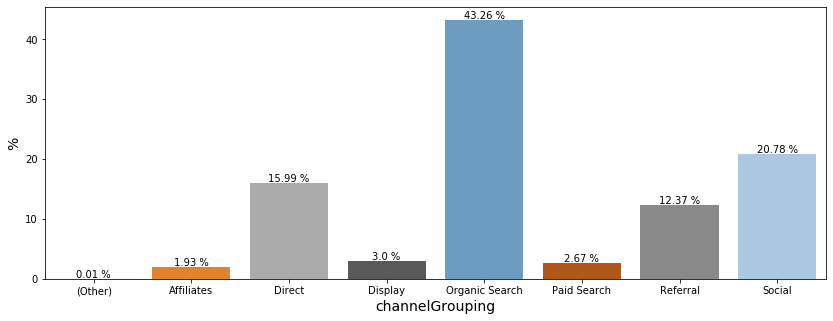

In [13]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'totals.transactionRevenue', data = channelGrouping_pct)
for index, row in channelGrouping_pct.iterrows():
    g.text(row.name, row['totals.transactionRevenue']+0.2, str(row['totals.transactionRevenue'])+" %", color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

In [14]:
channelGrouping_pct_spenders = pd.DataFrame(np.round(100*train_df.loc[train_df['totals.transactionRevenue']> 0].groupby('channelGrouping')['totals.transactionRevenue'].count()\
/train_df.groupby('channelGrouping')['totals.transactionRevenue'].count(),2)).reset_index().fillna(0)

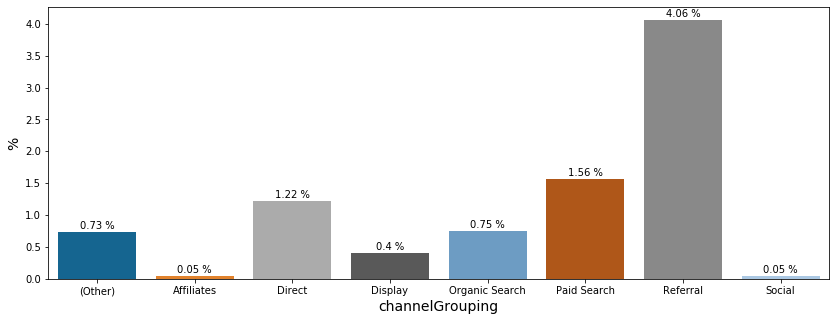

In [15]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'totals.transactionRevenue', data = channelGrouping_pct_spenders)
for index, row in channelGrouping_pct_spenders.iterrows():
    g.text(row.name, row['totals.transactionRevenue']+0.05, str(row['totals.transactionRevenue'])+" %", color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


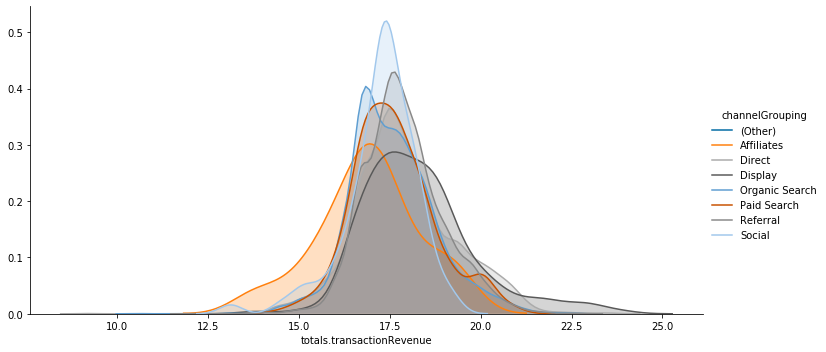

In [16]:
(sns.FacetGrid(train_df.loc[train_df['totals.transactionRevenue']> 0],hue='channelGrouping', height=5, aspect=2\
               ,hue_order = ['(Other)','Affiliates', 'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral', 'Social'])
 .map(sns.kdeplot, 'totals.transactionRevenue', shade=True )
 .add_legend()
);

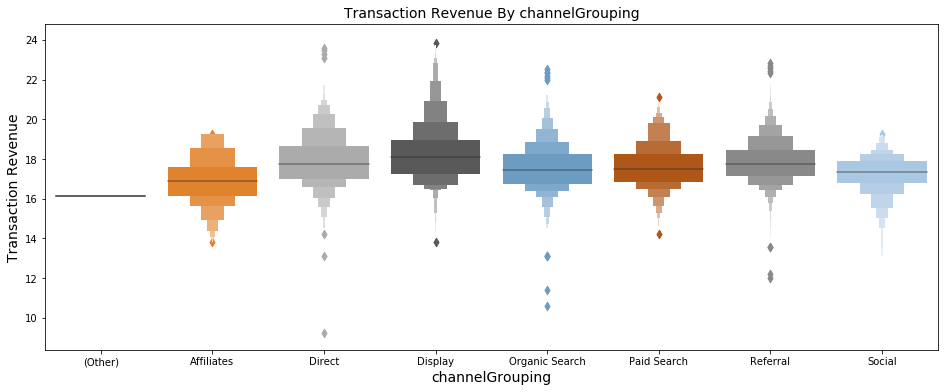

In [17]:
plt.figure(figsize = (16,6))
sns.boxenplot(x = 'channelGrouping', y='totals.transactionRevenue', data = train_df.loc[train_df['totals.transactionRevenue']> 0]\
             ,order = ['(Other)','Affiliates', 'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral', 'Social'])
plt.title('Transaction Revenue By channelGrouping', fontsize = 14)
plt.ylabel('Transaction Revenue', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

In [18]:
channelGrouping_revenue = pd.DataFrame(train_df.loc[train_df['totals.transactionRevenue']> 0].groupby('channelGrouping')['totals.transactionRevenue'].agg(['mean', 'std', 'median'])).reset_index()

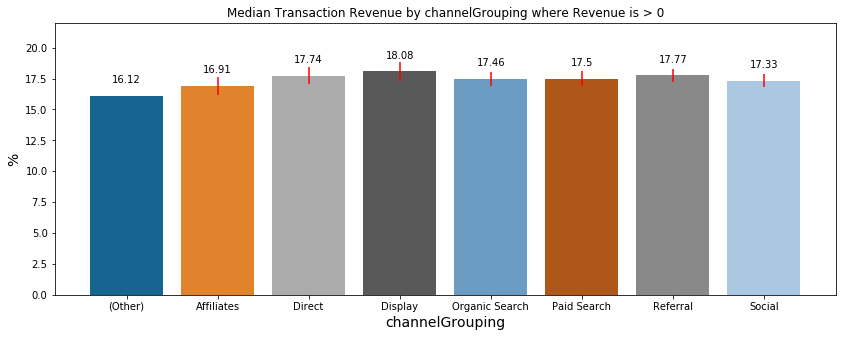

In [19]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'median', data = channelGrouping_revenue)
plt.errorbar(x = [0,1,2,3,4,5,6,7], y = channelGrouping_revenue['median'], yerr=channelGrouping_revenue['std']/2,fmt = 'none', c = 'r')
for index, row in channelGrouping_revenue.iterrows():
    g.text(row.name, row['median']+1.05, np.round(row['median'],2), color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14)
plt.ylim(0,22)
plt.title('Median Transaction Revenue by channelGrouping where Revenue is > 0');

Could play around with investigating all dimensions for ages.
will build an initial simple Random Forest Regressor to do some feature importance testing

To do that will need to sort out one hot encoding etc

In [20]:
del train_df

# Starting the Model

## Splitting the train set

In [3]:
train_df = feather.read_dataframe('data/encode_train_v2.feather')

In [4]:
train_df = train_df.sort_values('visitStartTime', ascending = True).reset_index(drop = True)

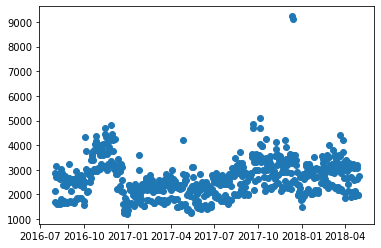

In [5]:
plt.plot_date(train_df['date'].value_counts().index, train_df['date'].value_counts().values);

In [6]:
test_df = feather.read_dataframe('data/encode_test_v2.feather')

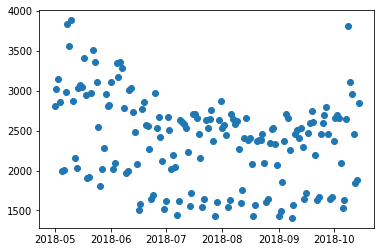

In [7]:
plt.plot_date(test_df['date'].value_counts().index, test_df['date'].value_counts().values);

In [8]:
train_df['date'].min()

Timestamp('2016-08-01 00:00:00')

In [9]:
train_df['date'].max()

Timestamp('2018-04-30 00:00:00')

In [10]:
test_df['date'].min()

Timestamp('2018-05-01 00:00:00')

Test dataset is after the train set. 

So when splitting training into validation set will take this into account. 

In [11]:
len(train_df)

1708337

In [12]:
len(test_df)

401589

In [13]:
len(test_df)/len(train_df)

0.23507598325154813

In [14]:
split_index = int(len(train_df)*(1-len(test_df)/len(train_df)))

In [15]:
len(train_df[:split_index])

1306748

In [16]:
train_set = train_df[:split_index]
valid_set = train_df[split_index:]

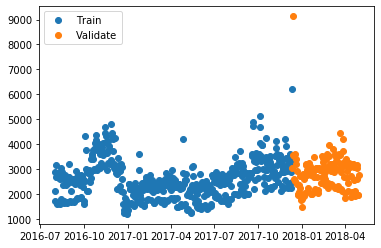

In [86]:
plt.plot_date(train_set['date'].value_counts().index, train_set['date'].value_counts().values)
plt.plot_date(valid_set['date'].value_counts().index, valid_set['date'].value_counts().values)
plt.legend(['Train', 'Validate']);

In [18]:
len(train_set.sample(frac = 0.1, random_state = 2))

130675

In [19]:
len(valid_set.sample(frac = 0.1, random_state = 2))

40159

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Do Sample First

In [21]:
train_sample = train_set.sample(frac = 0.1, random_state = 2).drop(['date', 'fullVisitorId','totals.totalTransactionRevenue', 'spender'], axis = 1)
train_ids = train_set.sample(frac = 0.1, random_state = 2)['fullVisitorId']

valid_sample = valid_set.sample(frac = 0.1, random_state = 2).drop(['date','fullVisitorId','totals.totalTransactionRevenue' ,'spender'], axis = 1)
valid_ids = valid_set.sample(frac = 0.1, random_state = 2)['fullVisitorId']

x_train = train_sample.drop('totals.transactionRevenue', axis = 1 )
y_train = train_sample['totals.transactionRevenue'].values

x_valid = valid_sample.drop('totals.transactionRevenue', axis = 1 )
y_valid = valid_sample['totals.transactionRevenue'].values

# Random Forest Regressor

In [101]:
m = RandomForestRegressor()
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [23]:
def rmse(x,y): return np.sqrt(mean_squared_error(x, y))
def print_score(m):
    train_pred_df = pd.DataFrame({'fullVisitorId': train_ids, 'PredictedRevenue' :m.predict(x_train), 'ActualRevenue':train_sample['totals.transactionRevenue'] })
    train_pred_gr = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
    val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids, 'PredictedRevenue' :m.predict(x_valid), 'ActualRevenue':valid_sample['totals.transactionRevenue']})
    val_pred_gr = val_pred_df.groupby('fullVisitorId', as_index = False).sum()
    
    
    res = [rmse(train_pred_df['PredictedRevenue'], train_pred_df['ActualRevenue']), rmse(val_pred_df['PredictedRevenue'].values, val_pred_df['ActualRevenue']),
           rmse(train_pred_gr['PredictedRevenue'], train_pred_gr['ActualRevenue']), rmse(val_pred_gr['PredictedRevenue'].values, val_pred_gr['ActualRevenue']),
          m.score(x_train, y_train), m.score(x_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    

In [48]:
print_score(m)

[0.7399915400260976, 2.108320398013157, 0.8629150599296804, -0.57653066349503]


Looks to be overfitting quite badly

In [49]:
preds = np.stack([t.predict(x_valid) for t in m.estimators_])

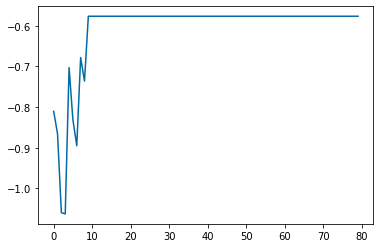

In [50]:
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

Num estimators defaults to 10, doesn't look like adding more will help

In [51]:
m = RandomForestRegressor(n_estimators=10)
m.fit(x_train, y_train)
print_score(m)

[0.7464120164936446, 1.9991172524313559, 0.8589123688384115, -0.42523677261476694]


In [52]:
m = RandomForestRegressor(n_estimators=20)
m.fit(x_train, y_train)
print_score(m)

[0.6749200901212272, 2.1911191436837827, 0.8865242957735476, -0.6976356969623831]


In [53]:
m = RandomForestRegressor(n_estimators=40)
m.fit(x_train, y_train)
print_score(m)

[0.6625288306904391, 2.0282892085726343, 0.891148466030405, -0.4558472965951368]


In [54]:
m = RandomForestRegressor(n_estimators=40, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[0.6553461908589604, 2.050387452041688, 0.8930697753880492, -0.49353987870639654, 0.23869646181762516]


Out of bag score better than validation score, but worse than train. Different time and overfitting an issue.

min_samples_leaf gross the trees less deeply. Requiring some minimum number of rows in each leaf. This results in: 
* There are less decision rules for each leaf node; simpler models should generalize better
* The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [55]:
m = RandomForestRegressor(n_estimators=10,min_samples_leaf = 3, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[1.0631224563755537, 1.5610801378319572, 0.7168522482823456, 0.12299568601113875, 0.14002046651230837]


In [56]:
m = RandomForestRegressor(n_estimators=10,min_samples_leaf = 30, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[1.5666035810257088, 1.4390751728157296, 0.39433148372352705, 0.24695434272124506, 0.27821750984911175]


In [57]:
m = RandomForestRegressor(n_estimators=10,min_samples_leaf = 10, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[1.3868136946250345, 1.4660900113201532, 0.5216152665505428, 0.22110649073684052, 0.2449441463928611]


max_features should help with generalisation as it samples number of columns to use for each split. 

In [58]:
m = RandomForestRegressor(n_estimators=10,min_samples_leaf = 30, max_features = 0.5,  oob_score=True)
m.fit(x_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[1.5839095346343741, 1.4264145959396977, 0.3835761130154182, 0.25912605254001386, 0.28172472711769214]


### Best Right Now

In [102]:
m = RandomForestRegressor(n_estimators=10,min_samples_leaf = 30, max_features = 0.5, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

[1.5804990337386764, 1.4372911683377003, 0.38418795638403924, 0.25026745668867456, 0.2823583319372419]


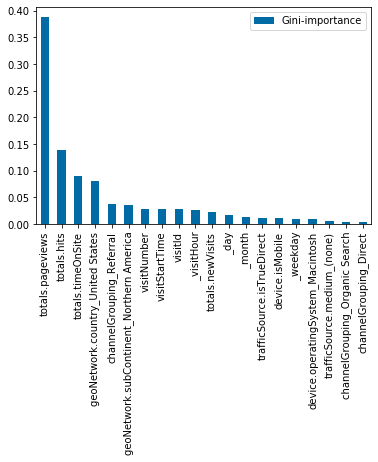

In [103]:
num_feats = 20
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, m.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].plot(kind='bar');

### Keep The best and do full data

In [104]:
to_keep = importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].index.tolist() + ['totals.transactionRevenue']

In [ ]:
train_full = train_set[to_keep]
train_ids_full = train_set['fullVisitorId']

valid_full = valid_set[to_keep]
valid_ids_full = valid_set['fullVisitorId']

x_train_full = train_full.drop('totals.transactionRevenue', axis = 1 )
y_train_full = train_full['totals.transactionRevenue'].values

x_valid_full = valid_full.drop('totals.transactionRevenue', axis = 1 )
y_valid_full = valid_full['totals.transactionRevenue'].values

In [24]:
def print_score_full(m):
    train_pred_df = pd.DataFrame({'fullVisitorId': train_ids_full, 'PredictedRevenue' :m.predict(x_train_full), 'ActualRevenue':train_full['totals.transactionRevenue'] })
    train_pred_gr = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
    val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids_full, 'PredictedRevenue' :m.predict(x_valid_full), 'ActualRevenue':valid_full['totals.transactionRevenue']})
    val_pred_gr = val_pred_df.groupby('fullVisitorId', as_index = False).sum()
    
    
    res = [rmse(train_pred_df['PredictedRevenue'], train_pred_df['ActualRevenue']), rmse(val_pred_df['PredictedRevenue'].values, val_pred_df['ActualRevenue']),
           rmse(train_pred_gr['PredictedRevenue'], train_pred_gr['ActualRevenue']), rmse(val_pred_gr['PredictedRevenue'].values, val_pred_gr['ActualRevenue']),
          m.score(x_train_full, y_train_full), m.score(x_valid_full, y_valid_full)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    

In [113]:
m_full = RandomForestRegressor(n_estimators=10,min_samples_leaf = 30, max_features = 0.5, oob_score=True)
m_full.fit(x_train_full, y_train_full)
print_score_full(m_full)

[1.8447170770604013, 1.6445735313975693, 0.4057926404715484, 0.24249495142320532, 0.3033839811851655]


In [116]:
train_pred_df = pd.DataFrame({'fullVisitorId': train_ids_full, 'PredictedRevenue' :m_full.predict(x_train_full), 'ActualRevenue':train_full['totals.transactionRevenue'] })
train_pred_df = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids_full, 'PredictedRevenue' :m_full.predict(x_valid_full), 'ActualRevenue':valid_full['totals.transactionRevenue']})
val_pred_df = val_pred_df.groupby('fullVisitorId', as_index = False).sum()

In [117]:
train_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    271041.432064
ActualRevenue       270676.787023
dtype: float64

In [118]:
val_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    56940.499168
ActualRevenue       58327.638532
dtype: float64

### Related Columns

In [120]:
from scipy.cluster import hierarchy as hc

In [124]:
corr = np.round(scipy.stats.spearmanr(x_train_full).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr, checks = False)
z = hc.linkage(corr_condensed, method='average')

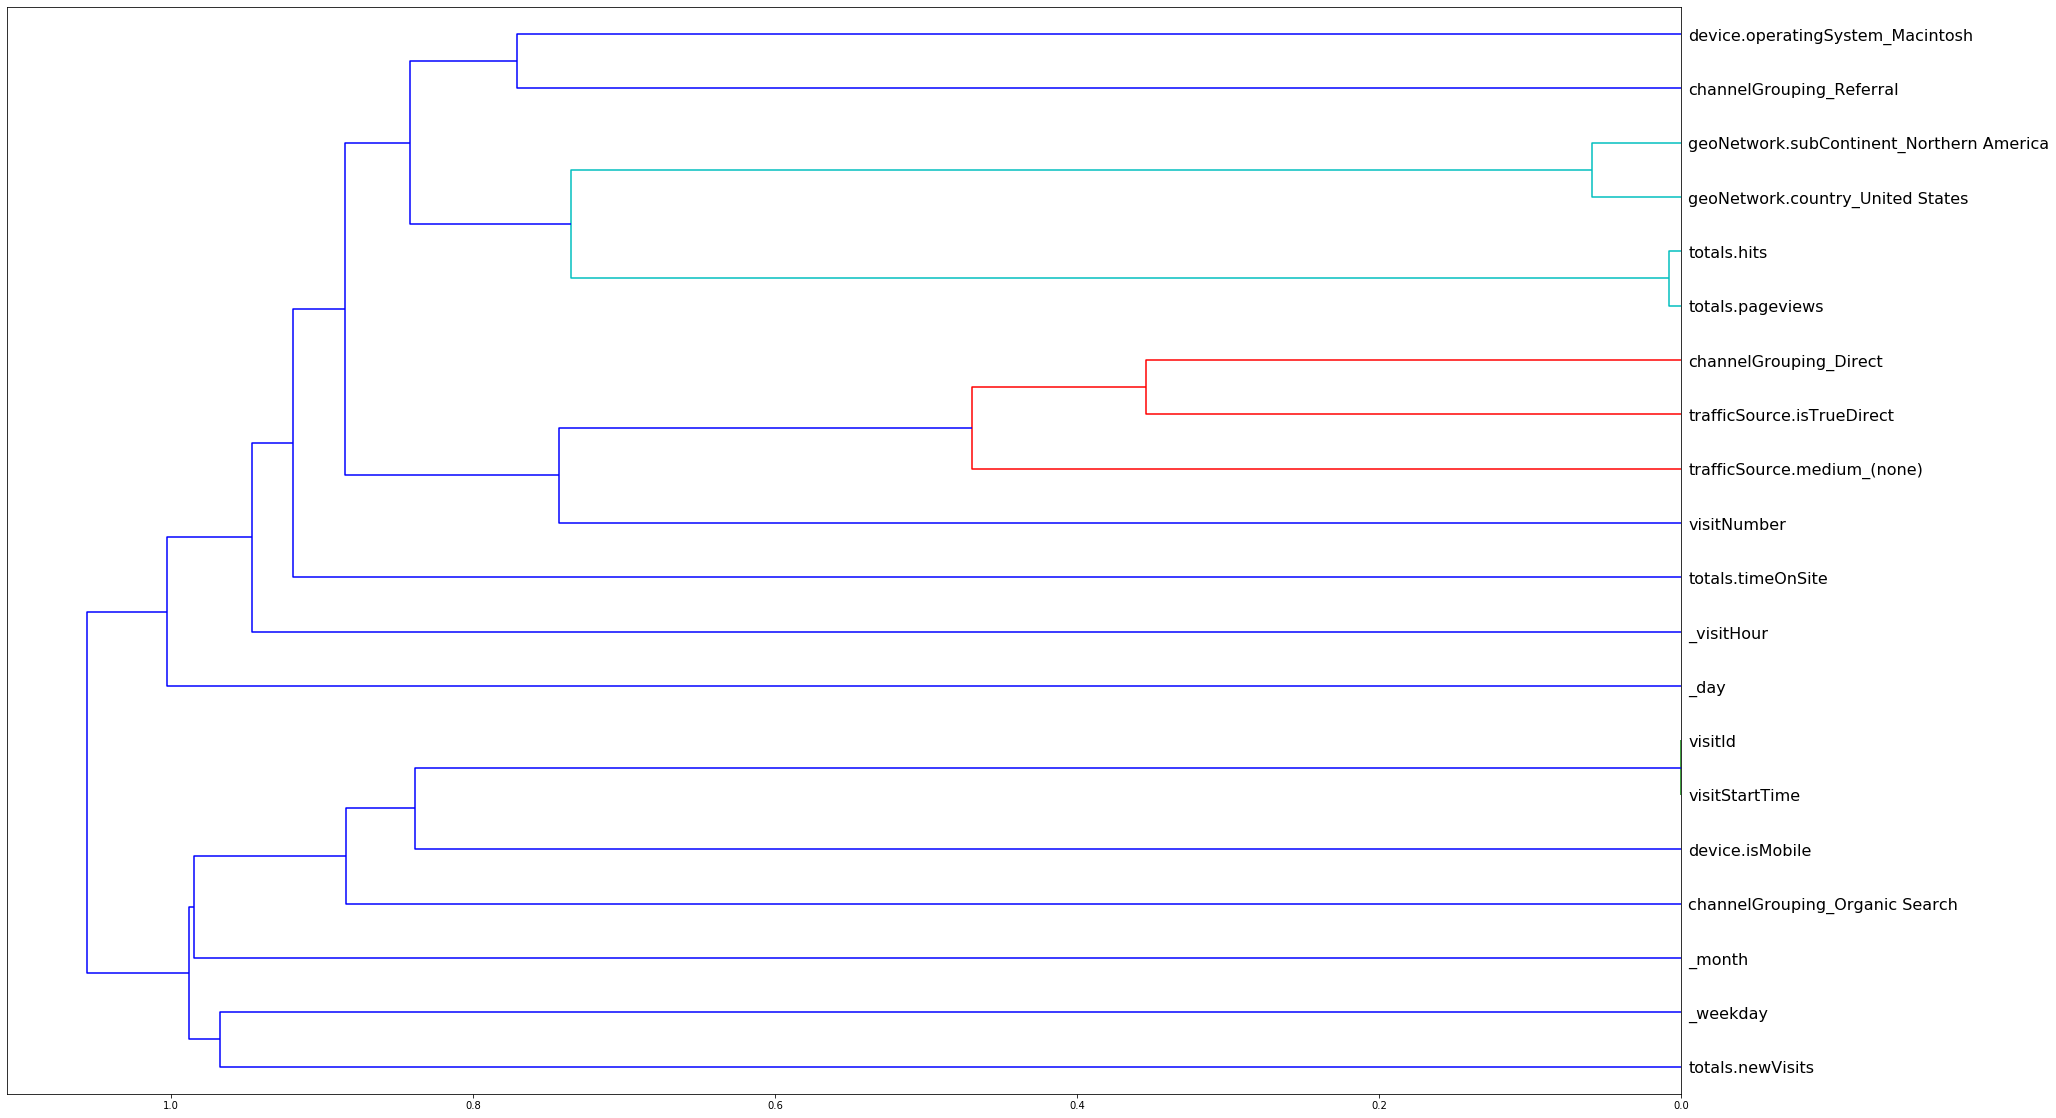

In [125]:
fig = plt.figure(figsize=(30,20))
dendrogram = hc.dendrogram(z, labels=x_train_full.columns, orientation='left', leaf_font_size=16);

In [129]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=10,min_samples_leaf = 30, n_jobs=-1, oob_score=True)
    m.fit(x_train_full, y_train_full)
    return m.oob_score_

In [130]:
get_oob(x_train_full)

0.3024098553235556

In [131]:
for c in ('geoNetwork.country_United States', 'geoNetwork.subContinent_Northern America', 'totals.hits', 'totals.pageviews',\
          'channelGrouping_Direct','trafficSource.isTrueDirect', 'trafficSource.medium_(none)'):
    print(c, get_oob(x_train.drop(c, axis=1)))

geoNetwork.country_United States 0.30335887312313903
geoNetwork.subContinent_Northern America 0.3011746882035059
totals.hits 0.30434051520074545
totals.pageviews 0.30379765621252064
channelGrouping_Direct 0.303127221431274
trafficSource.isTrueDirect 0.3033188675565015
trafficSource.medium_(none) 0.3016671301988719


## Removing correlated columns and doing one last Random Forest

In [132]:
to_keep

['totals.pageviews',
 'totals.hits',
 'totals.timeOnSite',
 'geoNetwork.country_United States',
 'channelGrouping_Referral',
 'geoNetwork.subContinent_Northern America',
 'visitNumber',
 'visitStartTime',
 'visitId',
 '_visitHour',
 'totals.newVisits',
 '_day',
 '_month',
 'trafficSource.isTrueDirect',
 'device.isMobile',
 '_weekday',
 'device.operatingSystem_Macintosh',
 'trafficSource.medium_(none)',
 'channelGrouping_Organic Search',
 'channelGrouping_Direct',
 'totals.transactionRevenue']

In [133]:
to_keep_new = [x for x in to_keep if x not in ('trafficSource.medium_(none)', 'geoNetwork.subContinent_Northern America')]

In [145]:
train_full = train_set[to_keep_new]
train_ids_full = train_set['fullVisitorId']

valid_full = valid_set[to_keep_new]
valid_ids_full = valid_set['fullVisitorId']

x_train_full = train_full.drop('totals.transactionRevenue', axis = 1 )
y_train_full = train_full['totals.transactionRevenue'].values

x_valid_full = valid_full.drop('totals.transactionRevenue', axis = 1 )
y_valid_full = valid_full['totals.transactionRevenue'].values

In [136]:
m_full = RandomForestRegressor(n_estimators=10,min_samples_leaf = 30, max_features = 0.5, oob_score=True)
m_full.fit(x_train_full, y_train_full)
print_score_full(m_full)

[1.8518442878494006, 1.6474044988454402, 0.40588618727649095, 0.24032433046818547, 0.3024172487289526]


In [140]:
train_pred_df = pd.DataFrame({'fullVisitorId': train_ids_full, 'PredictedRevenue' :m_full.predict(x_train_full), 'ActualRevenue':train_full['totals.transactionRevenue'] })
train_pred_df = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids_full, 'PredictedRevenue' :m_full.predict(x_valid_full), 'ActualRevenue':valid_full['totals.transactionRevenue']})
val_pred_df = val_pred_df.groupby('fullVisitorId', as_index = False).sum()

In [141]:
train_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    271274.675057
ActualRevenue       270676.787023
dtype: float64

In [142]:
val_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    58443.847354
ActualRevenue       58327.638532
dtype: float64

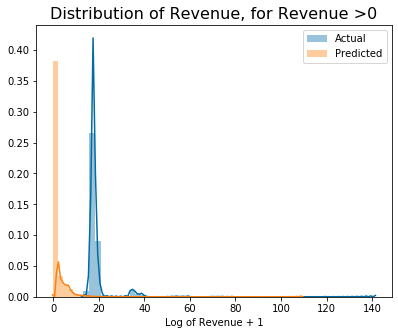

In [143]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(val_pred_df[val_pred_df['ActualRevenue'] > 0]["ActualRevenue"],hist = True, bins = 50)
ax = sns.distplot(val_pred_df[val_pred_df['PredictedRevenue'] > 0]["PredictedRevenue"],hist = True, bins = 50)
plt.legend(['Actual', 'Predicted'])
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16);

Still doesn't look great to be honest.
Overall look to have predicted ok, but the distribution is poor

# Gradient Boosting Regressor

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

In [23]:
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
print_score(gbr)

[1.625928479101852, 1.4815435357096436, 0.34666795418526963, 0.20091260478852066]


In [26]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.561314056452688, 1.4061536452166425, 1.6277813299920953, 1.434424829523343, 0.3451296787265144, 0.2508980309534107]


Better

In [39]:
gbr = GradientBoostingRegressor(min_samples_leaf = 10)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.5628978542817222, 1.407460193316941, 1.6297491984552577, 1.4358602447133506, 0.34380040323842886, 0.24950530625063738]


Worse

In [40]:
gbr = GradientBoostingRegressor(min_samples_leaf = 30)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.5679843649283518, 1.4094627666015376, 1.635179669671334, 1.4381758168420307, 0.3395221995544082, 0.24736813771175034]


Worse

In [41]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3, max_features = 0.5)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.5681154323149105, 1.4154075356906317, 1.636438533213597, 1.4435862514007514, 0.3394117766201227, 0.24100591470763166]


Worse

In [42]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3, max_depth = 10)
gbr.fit(x_train, y_train)
print_score(gbr)

[0.663794052351735, 1.6755371708857125, 0.6860489420491376, 1.721692827017909, 0.8816300449014782, -0.06361270967036736]


Much more overfitting on this one.

In [44]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3, max_depth = 2)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.6128496403178183, 1.4264571543039593, 1.6880405291267193, 1.4538093712174243, 0.3011844944174107, 0.2291092267959828]


Worse than default

In [45]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3, min_samples_split = 10)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.5615917375400026, 1.4080803303039116, 1.627795193988033, 1.4362767074881462, 0.34489671947944145, 0.24884381393745672]


Worse than default

In [46]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3, subsample= 0.5)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.5602034433998107, 1.4139354164223077, 1.6276622862157986, 1.4408066242329074, 0.34606100813470225, 0.24258390371810545]


Worse than default

In [50]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3, learning_rate= 0.01)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.6987417849724948, 1.4669506976368565, 1.789311152650102, 1.4944061657288115, 0.22477189645618667, 0.1847206908510024]


Worse than default

In [48]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3, learning_rate= 1)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.408569068619385, 1.713876210660607, 1.4637456155345225, 1.7449534372968385, 0.4669952689575342, -0.11284399288435432]


worse than default

## Feature importance

In [27]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3)
gbr.fit(x_train, y_train)
print_score(gbr)

[1.561314056452688, 1.4061908960126666, 1.6277813299920953, 1.4344661235542462, 0.3451296787265144, 0.2508583411025045]


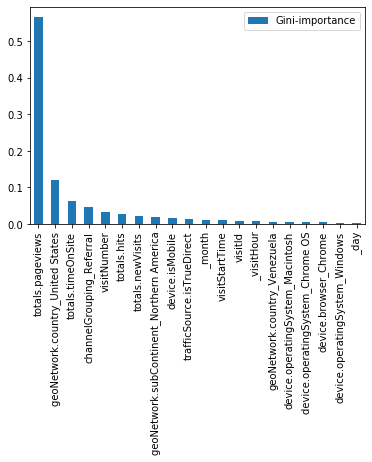

In [28]:
num_feats = 20
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, gbr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].plot(kind='bar');

In [30]:
to_keep = importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].index.tolist() + ['totals.transactionRevenue']

In [31]:
train_full = train_set[to_keep]
train_ids_full = train_set['fullVisitorId']

valid_full = valid_set[to_keep]
valid_ids_full = valid_set['fullVisitorId']

x_train_full = train_full.drop('totals.transactionRevenue', axis = 1 )
y_train_full = train_full['totals.transactionRevenue'].values

x_valid_full = valid_full.drop('totals.transactionRevenue', axis = 1 )
y_valid_full = valid_full['totals.transactionRevenue'].values

In [32]:
gbr = GradientBoostingRegressor(min_samples_leaf = 3)
gbr.fit(x_train_full, y_train_full)
print_score_full(gbr)

[1.5785155737737484, 1.4005190112094739, 2.012584508647216, 1.6611496669133838, 0.31852285179289286, 0.23538298555568782]


In [34]:
train_pred_df = pd.DataFrame({'fullVisitorId': train_ids_full, 'PredictedRevenue' :gbr.predict(x_train_full), 'ActualRevenue':train_full['totals.transactionRevenue'] })
train_pred_df = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids_full, 'PredictedRevenue' :gbr.predict(x_valid_full), 'ActualRevenue':valid_full['totals.transactionRevenue']})
val_pred_df = val_pred_df.groupby('fullVisitorId', as_index = False).sum()

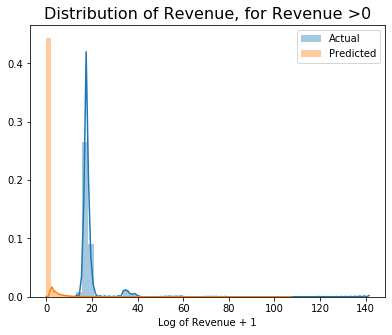

In [35]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(val_pred_df[val_pred_df['ActualRevenue'] > 0]["ActualRevenue"],hist = True, bins = 50)
ax = sns.distplot(val_pred_df[val_pred_df['PredictedRevenue'] > 0]["PredictedRevenue"],hist = True, bins = 50)
plt.legend(['Actual', 'Predicted'])
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16);

In [36]:
train_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    270676.787024
ActualRevenue       270676.787023
dtype: float64

In [37]:
val_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    52359.456173
ActualRevenue       58327.638532
dtype: float64

Not as good as the random forest on validation set

# Extra Trees Regressor

In [43]:
from sklearn.ensemble import ExtraTreesRegressor

In [48]:
etr = ExtraTreesRegressor()
etr.fit(x_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [52]:
print_score(etr)

[4.1199250525586494e-07, 1.5404075416889458, 4.233408290896702e-07, 1.5822334146985986, 0.9999999999999544, 0.10102698177868685]


In [50]:
preds = np.stack([t.predict(x_valid) for t in etr.estimators_])

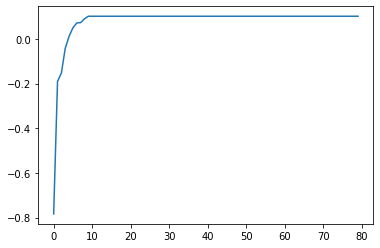

In [51]:
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

In [53]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 3)
etr.fit(x_train, y_train)
print_score(etr)

[0.8439450587134802, 1.4551505530537026, 0.8712888560548862, 1.4856731518946626, 0.8086611678926323, 0.19778414343661743]


In [54]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 30)
etr.fit(x_train, y_train)
print_score(etr)

[1.5226066567395322, 1.4088366828270533, 1.5876493812818648, 1.4386110740649476, 0.37719768578308355, 0.24803662779514835]


In [56]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 50)
etr.fit(x_train, y_train)
print_score(etr)

[1.5654291461554075, 1.4149712604082552, 1.6347952287725722, 1.4431513669732456, 0.3416731012928912, 0.24147373661458893]


In [55]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 100)
etr.fit(x_train, y_train)
print_score(etr)

[1.6012533987208113, 1.4151908701717981, 1.6751282061797939, 1.4447856049342946, 0.3111972086103756, 0.24123826511780144]


In [59]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 30, min_samples_split = 10)
etr.fit(x_train, y_train)
print_score(etr)

[1.5260019481190192, 1.4027497450043942, 1.5928885515471067, 1.432028465244785, 0.374416989917003, 0.2545203692449647]


In [60]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 30, min_samples_split = 50)
etr.fit(x_train, y_train)
print_score(etr)

[1.5225358494363077, 1.3989417662945662, 1.5888196092238123, 1.4267336696565827, 0.3772556100365047, 0.2585623124842409]


In [62]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 30, min_samples_split = 60)
etr.fit(x_train, y_train)
print_score(etr)

[1.5271453596732267, 1.4118816031510304, 1.594168879566396, 1.4414106628608039, 0.3734791577938515, 0.24478267662468545]


In [61]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 30, min_samples_split = 100)
etr.fit(x_train, y_train)
print_score(etr)

[1.5475937895965495, 1.4163805111242613, 1.6141729610175646, 1.4444426829261257, 0.35658863801913954, 0.23996206492806096]


In [65]:
etr = ExtraTreesRegressor(n_estimators=10,min_samples_leaf = 30, min_samples_split = 50)
etr.fit(x_train, y_train)
print_score(etr)

[1.5287906137783724, 1.4023324497224519, 1.5954899691773172, 1.4297267356985006, 0.37212847924275494, 0.2549638394539837]


In [66]:
etr = ExtraTreesRegressor(n_estimators=20,min_samples_leaf = 30, min_samples_split = 50)
etr.fit(x_train, y_train)
print_score(etr)

[1.5223052631882765, 1.3980815043560937, 1.5875469537639018, 1.4251734766344377, 0.3774442235508245, 0.2594739079840038]


In [68]:
etr = ExtraTreesRegressor(n_estimators=30,min_samples_leaf = 30, min_samples_split = 50, n_jobs = -1)
etr.fit(x_train, y_train)
print_score(etr)

[1.5212636147705811, 1.4044951583123584, 1.5868047871259925, 1.4337263926081358, 0.378295908676166, 0.2526640444331415]


In [67]:
etr = ExtraTreesRegressor(n_estimators=100,min_samples_leaf = 30, min_samples_split = 50, n_jobs = -1)
etr.fit(x_train, y_train)
print_score(etr)

[1.5220235910715418, 1.4002324456280941, 1.5881177088959517, 1.4280164154692212, 0.37767458520622066, 0.25719356394350457]


In [70]:
etr = ExtraTreesRegressor(n_estimators=20,min_samples_leaf = 30, min_samples_split = 50)
etr.fit(x_train, y_train)
print_score(etr)

[1.5231706086940082, 1.4024865570505411, 1.5885335851602589, 1.4304989383400462, 0.37673624601961214, 0.2548000810801415]


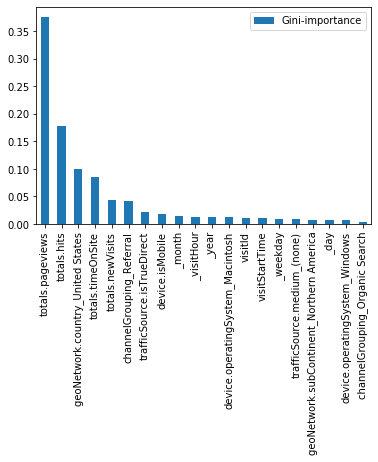

In [71]:
num_feats = 20
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, etr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].plot(kind='bar');

In [72]:
to_keep = importances.sort_values(by='Gini-importance', ascending = False)[:num_feats].index.tolist() + ['totals.transactionRevenue']
train_full = train_set[to_keep]
train_ids_full = train_set['fullVisitorId']

valid_full = valid_set[to_keep]
valid_ids_full = valid_set['fullVisitorId']

x_train_full = train_full.drop('totals.transactionRevenue', axis = 1 )
y_train_full = train_full['totals.transactionRevenue'].values

x_valid_full = valid_full.drop('totals.transactionRevenue', axis = 1 )
y_valid_full = valid_full['totals.transactionRevenue'].values

In [73]:
etr = ExtraTreesRegressor(n_estimators=20,min_samples_leaf = 30, min_samples_split = 50)
etr.fit(x_train_full, y_train_full)
print_score_full(etr)

[1.4863056035898081, 1.391924504827636, 1.8865971783952338, 1.640108785799558, 0.3958152133481727, 0.24473857761202733]


In [76]:
train_pred_df = pd.DataFrame({'fullVisitorId': train_ids_full, 'PredictedRevenue' :gbr.predict(x_train_full), 'ActualRevenue':train_full['totals.transactionRevenue'] })
train_pred_df = train_pred_df.groupby('fullVisitorId', as_index = False).sum()
val_pred_df = pd.DataFrame({'fullVisitorId': valid_ids_full, 'PredictedRevenue' :gbr.predict(x_valid_full), 'ActualRevenue':valid_full['totals.transactionRevenue']})
val_pred_df = val_pred_df.groupby('fullVisitorId', as_index = False).sum()

In [77]:
train_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    316559.200530
ActualRevenue       270676.787023
dtype: float64

In [78]:
val_pred_df[['PredictedRevenue', 'ActualRevenue']].sum()

PredictedRevenue    78772.593854
ActualRevenue       58327.638532
dtype: float64

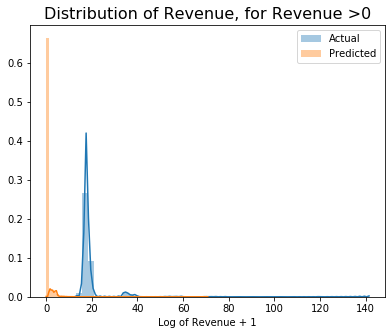

In [79]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(val_pred_df[val_pred_df['ActualRevenue'] > 0]["ActualRevenue"],hist = True, bins = 50)
ax = sns.distplot(val_pred_df[val_pred_df['PredictedRevenue'] > 0]["PredictedRevenue"],hist = True, bins = 50)
plt.legend(['Actual', 'Predicted'])
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16);

# Ada Boost

In [81]:
from sklearn.ensemble import AdaBoostRegressor

In [82]:
abr = AdaBoostRegressor()
abr.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [83]:
print_score(abr)

[2.1344769548229374, 1.9190557097941008, 2.280309986576784, 1.9983031577133816, -0.22393318403815332, -0.39524523939233597]


Struggling to get better than the random forest with rmse of approx 1.64.

This gets the overall log revenue pretty good on the validation set. Predicting 58443 when the actual is 58327. 

However as seen from the distributions it is still quite off. Not sure if further feature engineering will work, but can come back to that. 

Plan for next steps is to train a classifier for zero spend transactions. Then predict the spend 